In [2]:
import sys
sys.path.insert(0, "../..")

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from module.components import CONST
from module.simulation.masterequation import MasterEquation
from module.simulation.meanfield import MeanField
from module.base.network import Network

## Comparison
Here we'd like to compare the two algorithms for solving the master equation and the Lawrence-Meanfield method.

In [4]:
N = 200
Us = np.linspace(-0.1, 0.1, N)
Is = np.zeros(N)
probs_me = np.zeros((N, 40))
for i, U in enumerate(Us):
    set = MasterEquation(U, 0)
    probs = set.solve()
    Is[i] = set.expected_current(probs)
    probs_me[i] = probs

In [5]:
net = Network(1, 1, 1, [[0,0,0], [0,0,0]])
mf = MeanField(net)
N = 200
Us = np.linspace(-0.1, 0.1, N)
Is_mf = np.zeros(N)
states_mf = np.zeros(N)
for i, U in enumerate(Us):
    net.set_voltage_config([U, 0], 0)
    state = mf.numeric_integration_solve(N = 7)
    Is_mf[i] = -mf.calc_expected_electrode_current(state, 1) * CONST.electron_charge
    states_mf[i] = state[0]

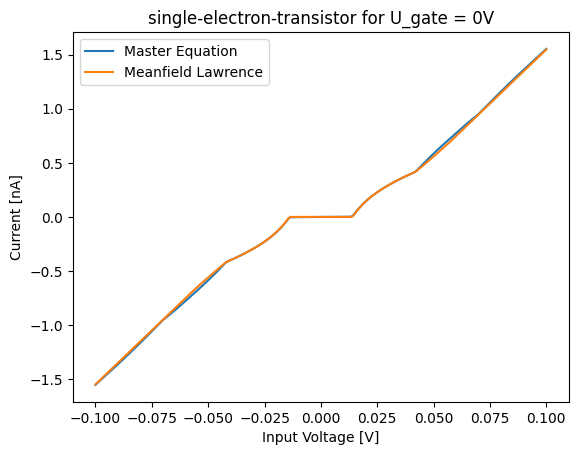

In [6]:
# currents
plt.plot(Us, Is, label = "Master Equation")
plt.plot(Us, Is_mf, label = "Meanfield Lawrence")
plt.xlabel("Input Voltage [V]")
plt.ylabel("Current [nA]")
plt.title("single-electron-transistor for U_gate = 0V")
plt.legend()
plt.savefig("../../output/set.png")

## Correlation between distribution error und output current error
It is estimated that, caused by the simplified dummy distribution in Lawrence-Meanfield (ground/ceiling) accuracy is lost.

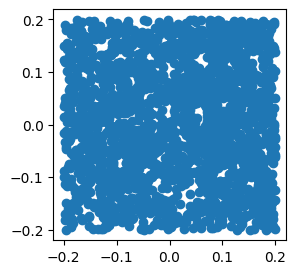

In [30]:
N = 2000
U_input = np.random.uniform(-0.2, 0.2, N)
U_gate = np.random.uniform(-0.2, 0.2, N)

plt.figure(figsize = (3,3))
plt.scatter(U_input, U_gate)

In [31]:
probs_me = np.zeros((N, 40))
probs_mf = np.zeros((N, 40))
states_mf = np.zeros((N, 1))

currents_me = np.zeros(N)
currents_mf = np.zeros(N)

In [32]:
set = MasterEquation(0, 0) # dummy variable
net = Network(1, 1, 1, [[0,0,0], [0,0,0]])
mf = MeanField(net)

for i in range(N):
    set_ = MasterEquation(U_input[i], U_gate[i])
    probs_me[i] = set_.solve()
    currents_me[i] = set_.expected_current(probs_me[i])
    
    net.set_voltage_config([U_input[i], 0], U_gate[i])
    states_mf[i] = mf.numeric_integration_solve(N = 10)
    currents_mf[i] = -mf.calc_expected_electrode_current(states_mf[i], 1) * CONST.electron_charge

In [33]:
floor_vals = np.squeeze(np.floor(states_mf))
p_ceil =  np.squeeze(states_mf) - floor_vals
p_floor = 1 - p_ceil
probs_mf[np.arange(N), floor_vals.astype("int") + 20] = p_floor
probs_mf[np.arange(N), floor_vals.astype("int") + 21] = p_ceil

In [34]:
def KL(probs_a, probs_b):
    return np.sum(probs_a * np.log(probs_a / (probs_b + 1e-50) + 1e-50), axis = -1)

In [36]:
KL_div = KL(probs_mf, probs_me)
abs_div = np.mean(np.abs(probs_me - probs_mf), axis = -1)

In [125]:
var_me = np.sum(set.phase_space ** 2 * probs_me, axis = -1) - np.sum(set.phase_space * probs_me, axis = -1)**2
var_mf = np.sum(set.phase_space ** 2 * probs_mf, axis = -1) - np.sum(set.phase_space * probs_mf, axis = -1)**2

var_ratio = var_me/(var_mf + 1e-10)

In [126]:
abs_errs = np.abs(currents_me - currents_mf)
rel_errs = np.abs(currents_mf - currents_me) / np.abs(currents_me + 1e-30)
current_errs = currents_mf - currents_me

currents_valid = np.where(currents_me > 0.01)[0]
select = np.where(np.logical_and(rel_errs > 0.1, currents_me > 0.01))[0]

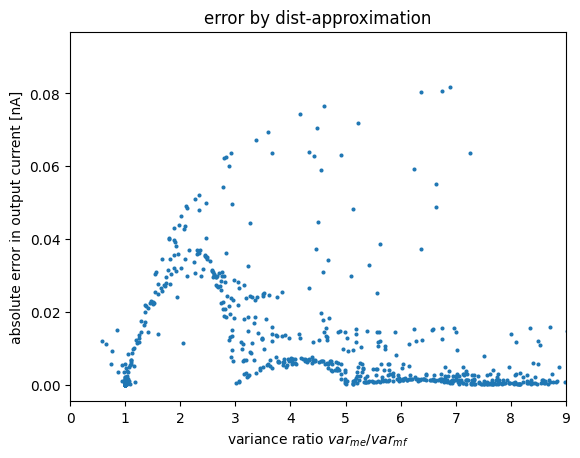

In [143]:
plt.scatter(var_ratio[currents_valid], abs_errs[currents_valid], marker = ".", s = 15)
plt.xlim(0,9)
plt.xlabel("variance ratio $var_{me}/var_{mf}$")
plt.ylabel("absolute error in output current [nA]")
plt.title("error by dist-approximation")
plt.savefig("../../output/error_by_lawrence_dist.png")

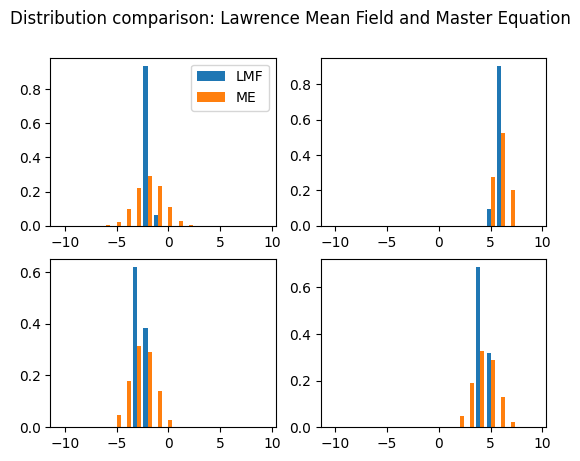

In [150]:
N_im = 2
window = np.arange(10, 30)

f = plt.figure()
for n in range(N_im ** 2):
    plt.subplot(N_im , N_im, n + 1)

    i = np.random.randint(N)
    #plt.title( "abs error :{:10.4f}".format(abs_errs[i]))
    plt.bar(np.arange(-20, 20)[window]-0.2, probs_mf[i][window], width = 0.4, label = "LMF")
    plt.bar(np.arange(-20, 20)[window]+0.2, probs_me[i][window], width = 0.4, label = "ME")

    if(n == 0):
        plt.legend()

f.suptitle("Distribution comparison: Lawrence Mean Field and Master Equation")
plt.savefig("../../output/LMF_ME_dist_comparison.png")
